In [32]:
# ResNet(Skip connection, Residual Block) 잔차를 레이어에 더해준다 

In [33]:
# conv - batchnorm - relu - conv - batchnorm - add - relu
import torch.nn as nn
import torch

conv1 = nn.Conv2d(3,32,3,padding=1)
batch1 = nn.BatchNorm2d(32)
relu = nn.ReLU()
conv2 = nn.Conv2d(32,64,3,padding=1)
batch2 = nn.BatchNorm2d(64)

X = torch.randn(2,3,32,32)
X_ = X # 스킾커넥션을 위해서 초기 입력을 저장

x = conv1(X)
x = batch1(x)
x = relu(x)
x = conv2(x)
x = batch2(x)
x.size(), X_.size()

(torch.Size([2, 64, 32, 32]), torch.Size([2, 3, 32, 32]))

In [34]:
downsample =  nn.Conv2d(3,64,1) # 채널 수 맞추기 위한 1x1 conv
down_x = downsample(X_)
down_x.size()

torch.Size([2, 64, 32, 32])

In [35]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim ):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, 3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, 3, padding=1)
        self.batch1 = nn.BatchNorm2d(hidden_dim)
        self.batch2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.downsample = nn.Conv2d(in_channels, out_channels, 1)
    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.batch1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.batch2(out)
        out += identity
        out = self.relu(out)
        return out

In [36]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.layer1 = BasicBlock(3,64,32)
        self.layer2 = BasicBlock(64,256,128)
        self.layer3 = BasicBlock(256,256,256)
        self.avgpool = nn.AvgPool2d(2)
        # 32x32 입력 -> layer1 -> pool(16x16) -> layer2 -> pool(8x8) -> layer3 -> pool(4x4)
        # 최종 크기: 256 * 4 * 4 = 4096
        self.fc1 = nn.Linear(256*4*4, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, num_classes)  # fc2 출력이 512이므로 수정
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.avgpool(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

In [37]:
# 데이터 로드 (인간 vs 말 분류)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # ResNet 입력 크기에 맞춤
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 데이터셋 로드
train_dataset = datasets.ImageFolder(
    root='data/horse-or-human/train',
    transform=transform
)
val_dataset = datasets.ImageFolder(
    root='data/horse-or-human/validation',
    transform=transform
)

# 데이터 로더
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 클래스 확인
print(f"클래스: {train_dataset.classes}")
print(f"학습 데이터: {len(train_dataset)}개")
print(f"검증 데이터: {len(val_dataset)}개")

# 모델 생성 (2개 클래스: 말, 사람)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(num_classes=2)
model.to(device)

# 손실 함수와 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"\nDevice: {device}")
model

클래스: ['horses', 'humans']
학습 데이터: 1027개
검증 데이터: 256개

Device: cpu


ResNet(
  (layer1): BasicBlock(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (downsample): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (layer2): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (downsample): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (layer3): BasicBlock(
    (conv1): Conv2d(256, 256, kernel_size=

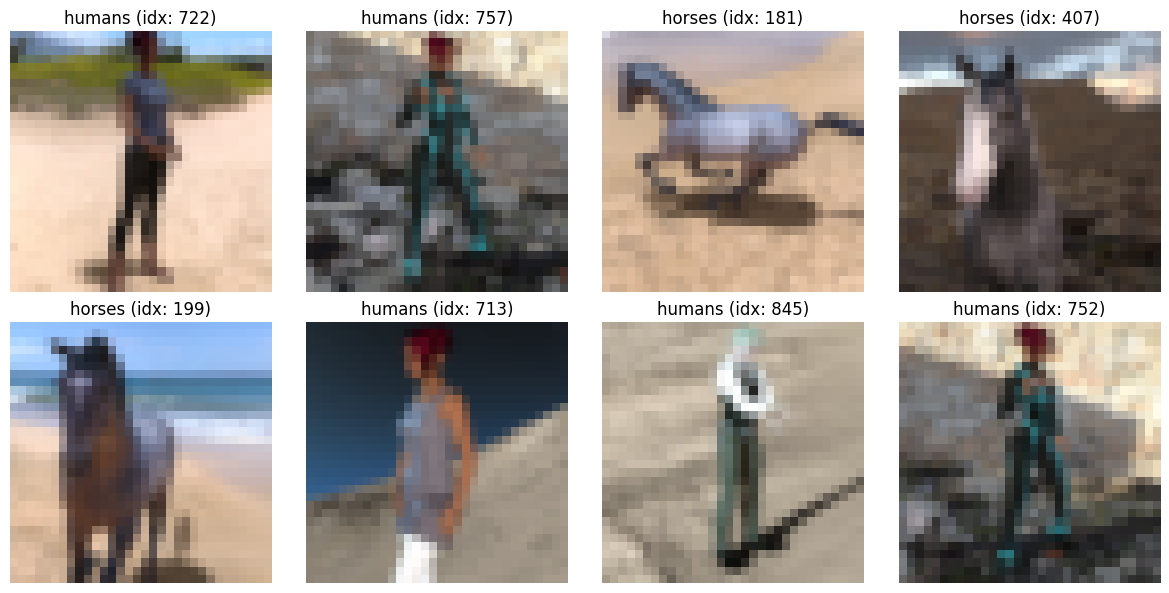


말: 500개, 사람: 527개


In [38]:
# 샘플 이미지 확인
import matplotlib.pyplot as plt
import random

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# 랜덤 인덱스 생성 (말과 사람 각각 4개씩)
num_samples = len(train_dataset)
random_indices = random.sample(range(num_samples), 8)

for idx, i in enumerate(random_indices):
    img, label = train_dataset[i]
    ax = axes[idx // 4, idx % 4]
    # 정규화 해제하여 시각화
    img_show = img.permute(1, 2, 0) * 0.5 + 0.5
    ax.imshow(img_show)
    ax.set_title(f'{train_dataset.classes[label]} (idx: {i})')
    ax.axis('off')
plt.tight_layout()
plt.show()

# 클래스별 개수 확인
horses = sum(1 for _, label in train_dataset if label == 0)
humans = sum(1 for _, label in train_dataset if label == 1)
print(f"\n말: {horses}개, 사람: {humans}개")

In [39]:
# 학습 함수
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# 평가 함수
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [40]:
# 학습 루프
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 50)

Epoch [1/10]
  Train Loss: 0.6491, Train Acc: 73.03%
  Val Loss: 3.4123, Val Acc: 50.00%
--------------------------------------------------
Epoch [2/10]
  Train Loss: 0.2178, Train Acc: 90.85%
  Val Loss: 1.5803, Val Acc: 65.23%
--------------------------------------------------
Epoch [2/10]
  Train Loss: 0.2178, Train Acc: 90.85%
  Val Loss: 1.5803, Val Acc: 65.23%
--------------------------------------------------
Epoch [3/10]
  Train Loss: 0.1198, Train Acc: 96.40%
  Val Loss: 1.2311, Val Acc: 60.16%
--------------------------------------------------
Epoch [3/10]
  Train Loss: 0.1198, Train Acc: 96.40%
  Val Loss: 1.2311, Val Acc: 60.16%
--------------------------------------------------
Epoch [4/10]
  Train Loss: 0.1166, Train Acc: 96.98%
  Val Loss: 0.3130, Val Acc: 85.16%
--------------------------------------------------
Epoch [4/10]
  Train Loss: 0.1166, Train Acc: 96.98%
  Val Loss: 0.3130, Val Acc: 85.16%
--------------------------------------------------
Epoch [5/10]
  Train

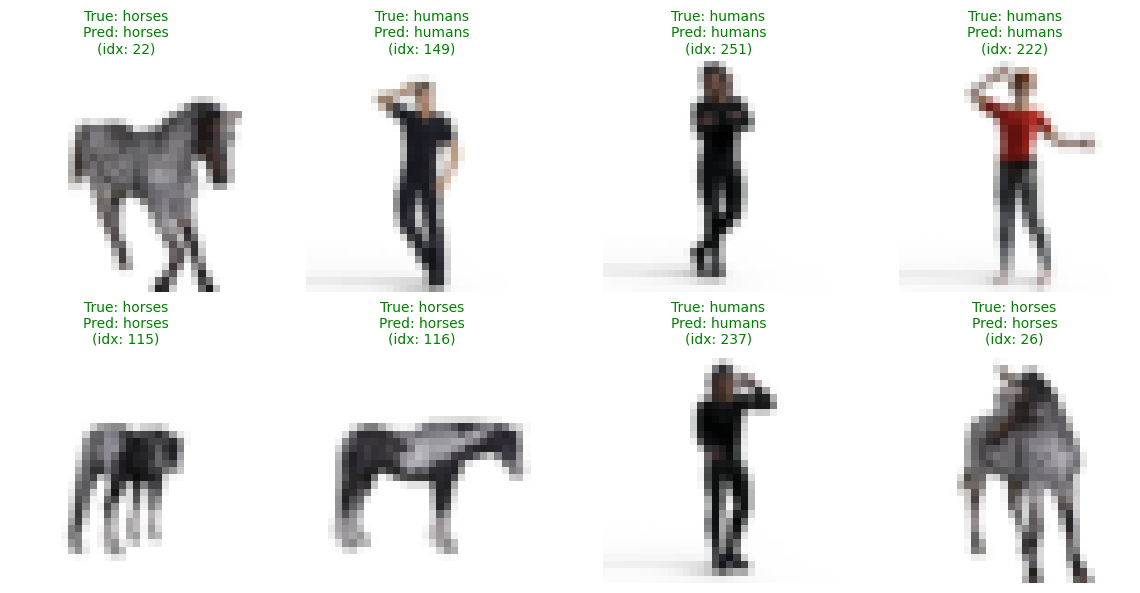

In [55]:
# 예측 결과 시각화
model.eval()

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# 랜덤하게 8개 선택
num_val_samples = len(val_dataset)
random_indices = random.sample(range(num_val_samples), 8)

for idx, i in enumerate(random_indices):
    img, true_label = val_dataset[i]
    ax = axes[idx // 4, idx % 4]
    
    # 예측
    with torch.no_grad():
        output = model(img.unsqueeze(0).to(device))
        _, predicted = torch.max(output, 1)
    
    # 시각화
    img_show = img.permute(1, 2, 0) * 0.5 + 0.5
    ax.imshow(img_show)
    
    true_class = val_dataset.classes[true_label]
    pred_class = val_dataset.classes[predicted.item()]
    color = 'green' if true_label == predicted.item() else 'red'
    
    ax.set_title(f'True: {true_class}\nPred: {pred_class}\n(idx: {i})', 
                 color=color, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()